# Приоритизация гипотез с использованием фреймворков ICE и RICE. Анализ результатов А/В-теста.

## Описание проекта

В крупном интернет-магазине отдел аналитики совместно с отделом маркетинга подготовлен ряд гипотез для увеличения выручки и конверсии пользователей.

Необходимо приоритизировать гипотезы и определить ту, которая будет проверена с помощью проведения А/В-теста. Для этого будут использованы фреймворки `ICE` и `RICE`.

Затем будет проведено А/В-тестирование, по итогам которого мы будем оценивать две метрики:
- конверсию посетителей в покупателей;
- сумма среднего чека.

Для этого мы проведем ряд действий:
1. Предварительно оценим имеющиеся данные и подготовим их к анализу;
2. Построим график кумулятивной выручки по группам;
3. Построим график кумулятивного среднего чека по группам;
4. Построим график относительного изменения кумулятивного чека по группам;
5. Построим график кумулятивного среднего количества заказов на покупателся по группам;
6. Построим график относительного изменения кумулятивного среднего количества заказов на пользователя;
7. Определим выбросы среди количества покупок и суммы чека;
8. Проведем статистический тест Манна-Уитни для сравнения среднего количества заказов в группах А и В.
9. Проведем статистический тест Манна-Уитни для сравнения средней суммы чека заказа для групп А и В.
10. Проведем те же тесты, но предварительно очистим данные от выбросов.

В ходе проекта используются три набора данных:
   1. **hypothesis.csv** - файл, содержащий информацию о гипотезах. В данном файле есть следующие столбцы:
      - `Hypothesis` — краткое описание гипотезы;
      - `Reach` — охват пользователей по 10-балльной шкале;
      - `Impact` — влияние на пользователей по 10-балльной шкале;
      - `Confidence` — уверенность в гипотезе по 10-балльной шкале;
      - `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
      
   2. **orders.csv** - файл, содержащий информацию о покупках пользователей. В данном файле есть следующие столбцы:
      - `transactionId` — идентификатор заказа;
      - `visitorId` — идентификатор пользователя, совершившего заказ;
      - `date` — дата, когда был совершён заказ;
      - `revenue` — выручка заказа;
      - `group` — группа A/B-теста, в которую попал заказ.
      
   3. **visitors.csv** - файл, содержащий информацию о посетителях интернет-магазина. В данном файле есть следующие столбцы:
      - `date` — дата;
      - `group` — группа A/B-теста;
      - `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка библиотек

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

## Загрузка и предварительная оценка данных

Сначала загрузим файл с гипотезами и заодно переведем названия столбцов в нижний регистр.

### Файл с гипотезами (hypothesis)

In [2]:
try:
    hypothesis = pd.read_csv('')
except:
    hypothesis = pd.read_csv('AB-test/hypothesis.csv')

In [3]:
hypothesis.columns = hypothesis.columns.str.lower()

In [4]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [5]:
hypothesis.info()
print('*'*40)
hypothesis.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
****************************************


(9, 5)

У нас  есть **9 гипотез**, пропуски и дубликаты отсутствуют. 

### Файл с покупками (orders)

Так как структура файлов с данными о покупках и посетителях имеет схожую структуру, создадим функцию, которая позволит нам открыть файлы, произвести предварительную обработку данных и посмотреть основную информацию о датафреймах.

In [6]:
def opening(path_1, path_2, date=[]):
    try:
        data = pd.read_csv(path_1)
        data = pd.read_csv(path_1, parse_dates=date)
        data.columns=data.columns.str.replace(' ', '_').str.lower()
    except:
        data = pd.read_csv(path_2)
        data = pd.read_csv(path_2, parse_dates=date)
        data.columns=data.columns.str.replace(' ', '_').str.lower()
        data['date']=data['date']
    display(data.sample(5, random_state=5))
    print('*'*50)
    data.info()
    print('*'*50)
    print('Самая ранняя дата в данных:', min(data['date']).date(), ',самая поздняя дата в данных:', max(data['date']).date())
    print('*'*50)
    display(data.shape)
    print('*'*50)
    print(f'Количество дубликатов:', data.duplicated().sum())
    return data

In [7]:
orders = opening('https://code.s3.yandex.net/datasets/orders.csv', 'AB-test/visits.csv', date=['date'])

,transactionid,visitorid,date,revenue,group
982,3778147089,4243832526,2019-08-10,8290,A
885,335158381,947532470,2019-08-05,5280,A
11,1919444843,927791387,2019-08-15,4499,B
235,395889669,2873491771,2019-08-23,599,B
578,1570911533,2038680547,2019-08-04,1530,A


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
**************************************************
Самая ранняя дата в данных: 2019-08-01 ,самая поздняя дата в данных: 2019-08-31
**************************************************


(1197, 5)

**************************************************
Количество дубликатов: 0


Предварительная оценка данных о покупках показала, что у нас есть информация о 1197 покупках. Все столбцы имеют нужный тип данных. Данные представлены за август 2019 года. Дубликаты отсутствуют.

### Файл с посетителями (visitors)

In [8]:
visitors = opening('https://code.s3.yandex.net/datasets/visitors.csv', 'AB-test/visitors.csv', date=['date'])

,date,group,visitors
42,2019-08-12,B,543
10,2019-08-11,A,718
17,2019-08-18,A,668
41,2019-08-11,B,721
40,2019-08-10,B,369


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
**************************************************
Самая ранняя дата в данных: 2019-08-01 ,самая поздняя дата в данных: 2019-08-31
**************************************************


(62, 3)

**************************************************
Количество дубликатов: 0


Предварительная оценка данных показала, что у нас есть информация о посетителях интернет-магазина за август 2019 года. Все столбцы имеют нужный тип данных. Дубликаты отсутствуют. Количество строк (62) говорит о том, что для обеих групп есть данные за каждый день (31 день в августе).

Данные готовы к дальнейшей работе.

## Приоритизация гипотез

Сначала проведем приоритизация гипотез с использованием фреймворка ICE

In [9]:
pd.set_option('max_colwidth', 130)

Так как нам предстоит дальше анализ и обсуждение гипотез, изменим индекс датафрейма, содержащего гипотезы так, чтобы у нас не гипотезы с индексом 0, так при анализе будет неудобно оперерировать "нулевой" гипотезой.

In [10]:
hypothesis.index = range(1,10)

In [11]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
2,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
3,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
4,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
5,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
7,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
8,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
9,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


#### Фреймворк ICE

Сначала приоритезируем гипотезы с помощью фреймворка ICE. Для его расчета нам необходимо оценить влияние гипотезы на пользователей (Impact), затраты на реализацию гипотезы (Effort) и наша уверенность в оценках, которые мы дали первым двум криетериям (Confidence). Оценка рассчитывается как произведение Impact на Confidence, деленное на Effort.

In [12]:
hypothesis['ICE']=(hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
hypothesis.sort_values(by='ICE', ascending=False)[['hypothesis', 'ICE']]

,hypothesis,ICE
9,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
8,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
7,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
3,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
2,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
4,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
5,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Тройка лидеров, идущих с заметным отрывом, такова:
   1. Запустить акцию, дающую скидку на товар в день рождения (№ 9);
   2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (№ 1);
   3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (№ 8).

In [13]:
hypothesis.iloc[[8,0,7]]

,hypothesis,reach,impact,confidence,efforts,ICE
9,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
8,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000


#### Фрейморк RICE

Фреймворк RICE схож по своей сути с ICE, но добавляется еще оценка охвата пользователей, на которых реализация гипотезы окадет влияние (Reach). Рассчитывается RICE как `Reach`x`Impact`x`Confidence`/`Effort`.

In [14]:
hypothesis['RICE']=(hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
hypothesis.sort_values(by='RICE', ascending=False)[['hypothesis', 'RICE']]

,hypothesis,RICE
8,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
3,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
7,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
9,"Запустить акцию, дающую скидку на товар в день рождения",16.2
4,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
2,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
5,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [15]:
hypothesis.iloc[[7,2,0]]

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
8,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
3,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0


Теперь, когда мы учли так же охват пользователей, на которых реализация гипотез оказала влияние, то тройка лидеров несколько изменилась:
Гипотеза под номером 8 оказалась на первом месте, вдвое опережая ближайшего преследователя. Это связано с тем, что она дает максимальный охват пользователей.
Гипотеза под номером 9 наоборот выпала из тройки лидеров,, так как имела минимальный охват, вместо нее в тройке оказалась гипотеза № 3, о которой мы довольно уверенно можем сказать, что она окажет небольшое воздействие на большой сегмент пользователей и не потребует больших затрат на реализацию.

Исходя из анализа `ICE` и `RICE` наилучшие значения показала **гипотеза номер 8 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"**. С большой долей уверенности мы можем предполагать, что она охватит всех пользователей и сможет оказать достаточно большое воздействие на них, но при этом реализация данной гипотезы потребует средних затрат.
Можно рассмотреть данную гипотезу в качестве приоритетной и провести А/В-тест для оценки реакции пользователей на форму подписки на все основные страницы.

## Анализ результатов А/В-теста

### Подготовка к проведению теста

Для правильного проведения теста и формирования результатов важно избежать характерных для А/В-тестов ошибок, а именно:
   - количество пользователей в группах должно быть достаточно большим;
   - количество пользователей в группах должно быть примерно равным;
   - длительность проведения теста не должна быть слишком маленькой или слишком большой;
   - необходимо обработать аномальные значения в случае их появления.

В рамках данного исследования длительность теста задана услвоием - **31 день**.

Аномальные значения можно выявить не следующих этапах исследования.

Достаточный размер групп и их равность мы проверим сразу. Для этого посчитаем количество уникальных покупателе

Размер групп достаточно большой, чтобы значения отдельного покупателя не влияли на общие тенденции.

In [16]:
groupB = visitors[visitors['group'] == 'B']['visitors'].sum()
groupB

18916

In [17]:
groupA = visitors[visitors['group'] == 'A']['visitors'].sum()
groupA

18736

In [18]:
print('Относительное различие между группами теста составляет:', '{0:.2%}'.format(1 - groupA/groupB))

Относительное различие между группами теста составляет: 0.95%


Относительная разница между группами составляет менее 1%. Это приемлимый результат для проведения теста.

При проведении А/В-тестов могут возникать ситуации, когда один и тот же покупатель попадает в обе группы. Это негативно сказывается на результатах теста.

Проверим, есть ли в нашем тесте такие и пользователи, и если есть, то удалим их данные.

In [19]:
orders['visitorid'].drop_duplicates().count()

1031

В сырых данных у нас есть информация о 1031 покупателе.

In [20]:
ordersA = orders[orders['group'] == 'A']['visitorid'].drop_duplicates()

In [21]:
ordersB = orders[orders['group'] == 'B']['visitorid'].drop_duplicates()

In [22]:
len(np.intersect1d(ordersA, ordersB).tolist())

58

58 пользователей совершали покупки, будучи и в группе А и в группе В, по крайней мере логи дают именно такую картину. Удалим таких пользователей из датафрейма.

In [23]:
orders = orders[orders['visitorid'].isin(np.intersect1d(ordersA, ordersB).tolist())==False]
orders['visitorid'].drop_duplicates().count()

973

Итого в дальнейшем анализе мы будем работать с 973 покупателями.

Важно отметить, что мы не удаляли пользователей, которые попали в 2 группы из данных о посещениях, так как это невозможно из-за того, что у нас только обобщенные сведения по посещениям. Однако так как количество заказов всего чуть более 1000, то "двойные" заказы 58 пользователей могут оказать заметное влияние, при этом количество посетителей исчисляется десятками тысяч, и соответственно посещения 58 "лишних" пользователей не окажет большого влияния на расчеты.

### Построение графика кумулятивной выручки по группам

Сначала создадим таблицу с уникальными сочетаниями дат и групп.

In [24]:
dates_groups = orders[['date', 'group']].drop_duplicates()
dates_groups

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


Создадим таблицу, в которой для каждой группы на каждую дату будут содержаться кумулятивные значения количества покупок, количества покупателей и выручки.

In [25]:
orders_agg = (dates_groups
              .apply(
                  lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                  .agg({'date':'max', 'group':'max', 'transactionid':'nunique', 'visitorid':'nunique', 'revenue':'sum'}), 
                  axis=1)
              .sort_values(by=['date', 'group']).reset_index(drop=True)
             )
orders_agg = orders_agg.rename(columns={'transactionid':'orders', 'visitorid':'buyers'})
orders_agg

,date,group,orders,buyers,revenue
0,2019-08-01,A,23,19,142779
1,2019-08-01,B,17,17,59758
2,2019-08-02,A,42,36,234381
3,2019-08-02,B,40,39,221801
4,2019-08-03,A,66,60,346854
...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610
58,2019-08-30,A,460,437,3311413
59,2019-08-30,B,531,511,4955833
60,2019-08-31,A,468,445,3364656


Для расчета средней выручки не требуются данные о количестве посетителей, но для последующих расчетов нам потребуются данные и из датафрейма `orders` и из датафрейма `visitors`. Поэтому сразу сделаем кумулятивные расчеты для посетителей и объединим все данные в один датафрейм.

In [26]:
visitors_agg= (dates_groups
               .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                     .agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis=1)
               .sort_values(by=['date', 'group']).reset_index(drop=True)
              )
visitors_agg

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,1338
3,2019-08-02,B,1294
4,2019-08-03,A,1845
...,...,...,...
57,2019-08-29,B,17708
58,2019-08-30,A,18037
59,2019-08-30,B,18198
60,2019-08-31,A,18736


In [27]:
cumdata_agg = orders_agg.merge(visitors_agg, on=['date', 'group'])
cumdata_agg

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708
58,2019-08-30,A,460,437,3311413,18037
59,2019-08-30,B,531,511,4955833,18198
60,2019-08-31,A,468,445,3364656,18736


Разобьем кумулятивные данные о покупках по группам.

In [28]:
cumrevenueA=cumdata_agg[orders_agg['group'] == 'A'].reset_index(drop=True)
cumrevenueA.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-02,A,42,36,234381,1338
2,2019-08-03,A,66,60,346854,1845
3,2019-08-04,A,77,71,388030,2562
4,2019-08-05,A,99,92,474413,3318


In [29]:
cumrevenueB=cumdata_agg[orders_agg['group'] == 'B'].reset_index(drop=True)
cumrevenueB.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,B,17,17,59758,713
1,2019-08-02,B,40,39,221801,1294
2,2019-08-03,B,54,53,288850,1803
3,2019-08-04,B,68,66,385740,2573
4,2019-08-05,B,89,87,475648,3280


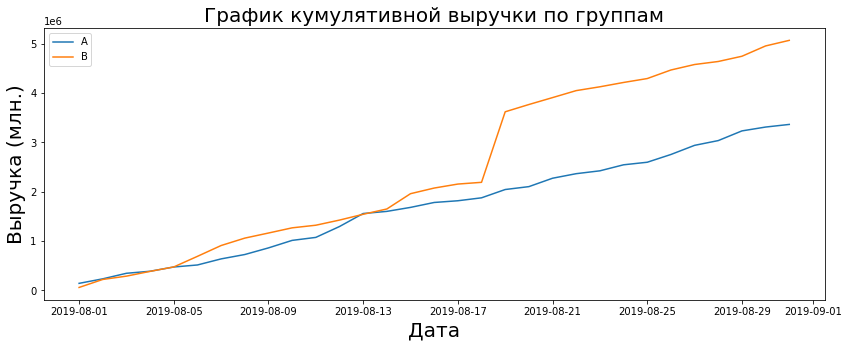

In [30]:
plt.figure(figsize=(14,5))
plt.plot(cumrevenueA['date'], cumrevenueA['revenue'], label='A')
plt.plot(cumrevenueB['date'], cumrevenueB['revenue'], label='B')
plt.legend()
plt.title('График кумулятивной выручки по группам', fontsize=20)
plt.xlabel('Дата', fontsize=20)
plt.ylabel("Выручка (млн.)",  fontsize=20);

Мы можем наблюдать, что выручка в обеих группах стабильно растет. В первой половине тестирования заметно небольшое преимущество выручки в группе `B`, после чего в группе `B` выручка резко выросла и далее вплоть до конца теста имела такую же динамику, что и группа `A`. Практически наверняка в результатах есть выброс - какая-то одна супер-покупка, которая значительно повлияла на поведение графика группы `B`, либо резкий всплеск покупательской активности.

### Построение графика кумулятивного среднего чека по группам

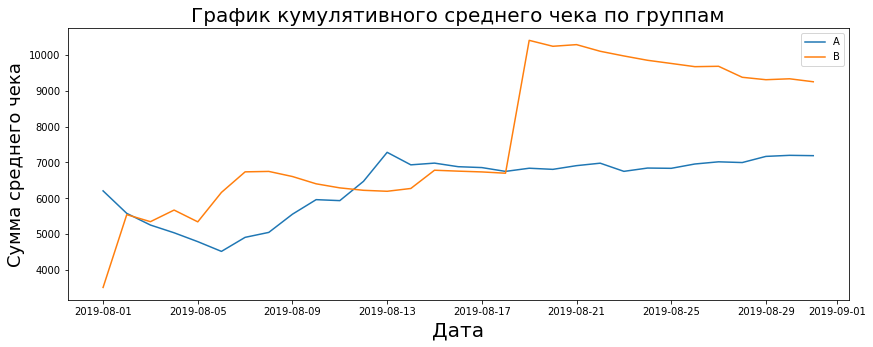

In [31]:
plt.figure(figsize=(14,5))
plt.plot(cumrevenueA['date'], cumrevenueA['revenue']/cumrevenueA['orders'], label='A')
plt.plot(cumrevenueB['date'], cumrevenueB['revenue']/cumrevenueB['orders'], label='B')
plt.legend()
plt.title('График кумулятивного среднего чека по группам', fontsize=20)
plt.xlabel('Дата', fontsize=20)
plt.ylabel("Сумма среднего чека",  fontsize=18);

Мы видим колебания в начале графика, после чего кривая группы `B` стабилизировалась вплоть до окончания теста, а кривая группы `A` резко выросла, а затем начала постепенное снижение. Из этого мы можем сделать вывод, что выброс на графике кумулятивной средней выручки связан не со скачком количества покупателей, а с одной большой покупкой, которая также оказала большое влияние на кумулятивный средний чек.

### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A.

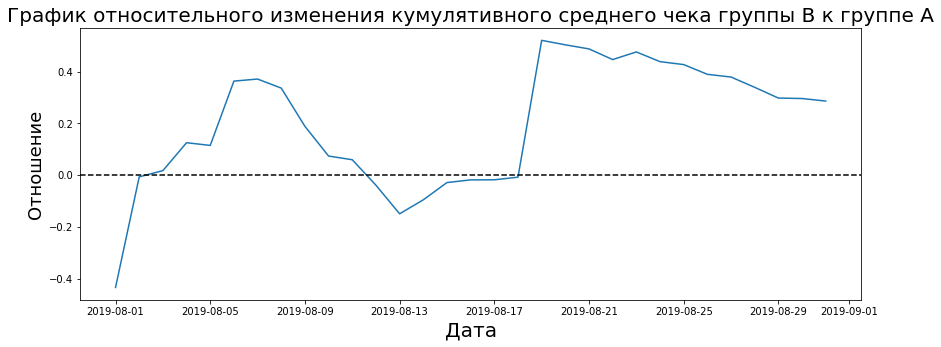

In [32]:
plt.figure(figsize=(14,5))
plt.plot(cumrevenueA['date'], (cumrevenueB['revenue']/cumrevenueB['orders'])/(cumrevenueA['revenue']/cumrevenueA['orders']) - 1)
plt.title('График относительного изменения кумулятивного среднего чека группы В к группе А', fontsize=20)
plt.xlabel('Дата', fontsize=20)
plt.ylabel("Отношение",  fontsize=18)
plt.axhline(y=0, color='black', linestyle='--');

Мы видим, что в начале графика соотношение сильно колеблется. Такое поведение характерно для ранних этапов теста, особенно учитывая, что выборка покупателей не слишком велика. В середине теста появляется тренд на стабилизацию соотношения в районе 0, однако затем происходит резкий скачок вверх, после которого следует постепенное снижение. Выброс сильно искажает картину и не дает оценить результаты группы В.

### Построение графика кумулятивного среднего количества заказов на посетителя по группам

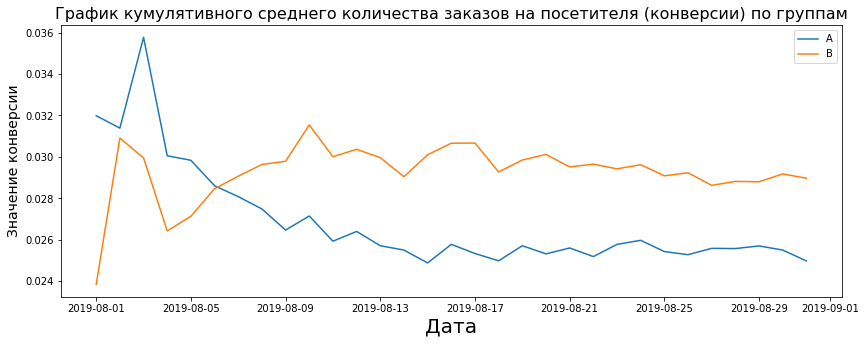

In [33]:
plt.figure(figsize=(14,5))
plt.plot(cumrevenueA['date'], cumrevenueA['orders']/cumrevenueA['visitors'], label='A')
plt.plot(cumrevenueB['date'], cumrevenueB['orders']/cumrevenueB['visitors'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя (конверсии) по группам', fontsize=16)
plt.xlabel('Дата', fontsize=20)
plt.ylabel("Значение конверсии",  fontsize=14);

Мы можем наблюдать нестабильные графики в начале теста, после чего они стабилизируются с незначительными колебаниями на уровне примерно **2.6%** для группы `А` и **2.9-3%** для группы `В`. Конверсия группы `B` стабильно выше конверсии группы `A`.

### Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

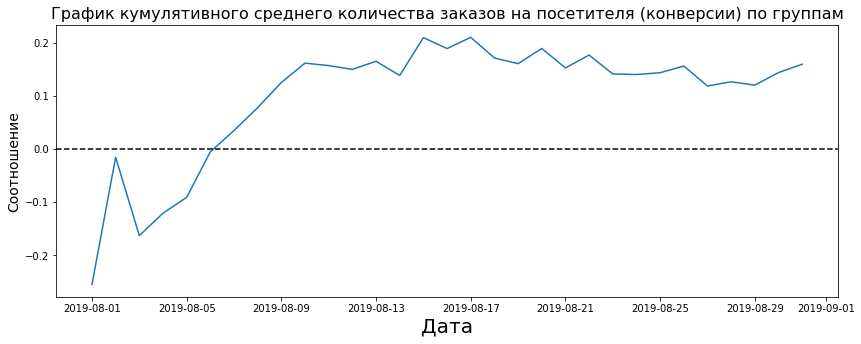

In [34]:
plt.figure(figsize=(14,5))
plt.plot(cumrevenueA['date'], (cumrevenueB['orders']/cumrevenueB['visitors'])/(cumrevenueA['orders']/cumrevenueA['visitors']) - 1)
plt.title('График кумулятивного среднего количества заказов на посетителя (конверсии) по группам', fontsize=16)
plt.xlabel('Дата', fontsize=20)
plt.ylabel("Соотношение",  fontsize=14)
plt.axhline(y=0, color='black', linestyle='--');

Конверсия пользователей из группы B заметно выше конверсии пользователей их группы А - окодо 20% на протяжении почти всего теста. Можно предположить, что нововведение сделало процесс покупки проще или быстрее.

### Построение точечного графика количества заказов по пользователям

Создадим датафрейм, содержащий информацию о пользователях и количестве их заказов.

In [35]:
orders_by_users = orders.groupby('visitorid', as_index=False).agg({'transactionid':'nunique'})
orders_by_users.columns = ['users', 'orders']
orders_by_users.sort_values(by='orders', ascending=False).head(10)

,users,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


У нас есть несколько пользователей с тремя покупками. У остальных 2 или 1 покупка.

Для построение графика создадим объект Series, в котором будет количество элементов равное количеству покупателей.

In [36]:
x_values = range(len(orders_by_users))

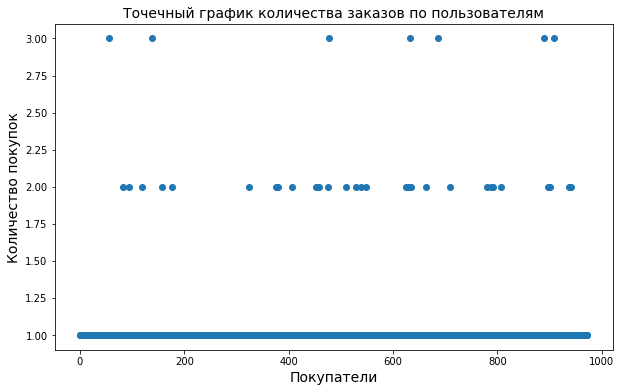

In [37]:
plt.figure(figsize=(10,6))
plt.scatter(x_values, orders_by_users['orders'])
plt.xlabel('Покупатели', fontsize=14)
plt.ylabel('Количество покупок', fontsize=14)
plt.title('Точечный график количества заказов по пользователям', fontsize=14);

Подавляющее колиечство покупателей совершили всего одну покупку, также есть небольшое количество покупателей с двумя покупками и всего несколько покупателей с тремя покупками. Возможно, стоит разобраться, в чем причина такого нихкого уровня удержания пользователей. Для того, чтобы точно определить, что считать выбросом, посмотрим 95-й и 99-й процентили.

### Расчет 95-го и 99-го перцентилей для количества заказов по пользователям.

In [38]:
percent1 = np.percentile(orders_by_users['orders'],[95, 99])

In [39]:
print(f'95-й перцентиль для количества покупок на пользователя равен {percent1[0]}, а 99-й перцентиль равен {percent1[1]}.')

95-й перцентиль для количества покупок на пользователя равен 1.0, а 99-й перцентиль равен 2.0.


Не более 5% пользователей оформили более одной покупки и не более 1% пользователей оформили более 2 покупок. Стоит признать выбросами пользователей с двумя и более покупками.

### Построение  точечного графика стоимостей заказов

Порядок действий схож с тем, который был при построении точечного графика количества покупок, только не проводить группировку.

In [40]:
x1_values = range(len(orders['revenue']))

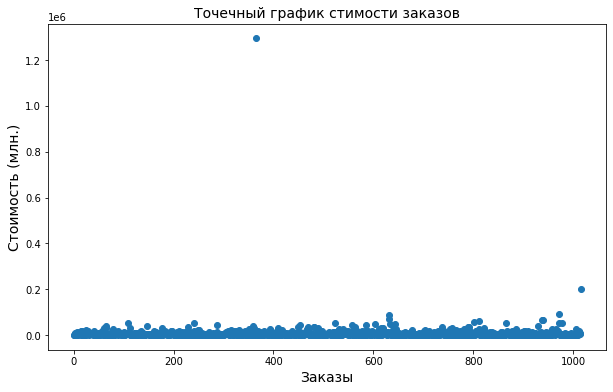

In [41]:
plt.figure(figsize=(10,6))
plt.scatter(x1_values, orders['revenue'])
plt.xlabel('Заказы', fontsize=14)
plt.ylabel('Стоимость (млн.)', fontsize=14)
plt.title('Точечный график стимости заказов', fontsize=14);

Мы видим, что стимость практически всех заказов не превышает 100 000. Но есть два явных выброса: один около 200 000 и один более 1 200 000. Воспользуемся процентилями, чтобы определиться с выбросами наверняка.

###  Расчет 95-го и 99-го перцентилей стоимости заказов

In [42]:
percent2 = np.percentile(orders['revenue'], [95, 99])

In [43]:
print(f'95-й перцентиль для количества покупок на пользователя равен {percent2[0]}, а 99-й перцентиль равен {percent2[1]}.')

95-й перцентиль для количества покупок на пользователя равен 26785.0, а 99-й перцентиль равен 53904.0.


Только 5% покупок были дороже 26785 и лишь 1% покупок был дороже 53904.

### Подготовка к расчету статистических значимостей.

Для понимания результатов А/В-тест нам необходимо:
- Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным;
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным;
- Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным;
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.
***
Под "очищенными" данными понимаются данные с удаленными выбросами.
***
Для проведения указанных расчетов необходимо сначала подготовить данные. Нам потребуется:

1) дата (`date`);

2) количество заказов в выбранную дату в группе A (`orders_per_date_A`);

3) суммарная выручка в выбранную дату в группе A (`revenue_per_date_A`);

4) количество заказов в выбранную дату в группе B (`orders_per_date_B`);

5) суммарная выручка в выбранную дату в группе B (`revenue_per_date_A`);

6) суммарное количество заказов до выбранной даты включительно в группе A (`orders_cum_B`);

7) суммарная выручка до выбранной даты включительно в группе A (`revenue_cum_A`);

8) суммарное количество заказов до выбранной даты включительно в группе B (`orders_cum_B`);

9) суммарная выручка до выбранной даты включительно в группе B(`revenue_cum_A`);

10) количество пользователей в выбранную дату в группе A (`visitors_per_dateA`);

11) количество пользователей в выбранную дату в группе B (`visitors_per_date_B`);

12) количество пользователей до выбранной даты включительно в группе A (`visitors_cum_A`);

13) количество пользователей до выбранной даты включительно в группе B (`visitors_cum_B`).
***

In [44]:
orders_daily_A = orders[orders['group'] == 'A'].groupby('date', as_index=False).agg({'transactionid': pd.Series.nunique, 'revenue':'sum'})
orders_daily_A.columns= ['date', 'orders_per_date_A', 'revenue_per_date_A']
orders_daily_A.head()

,date,orders_per_date_A,revenue_per_date_A
0,2019-08-01,23,142779
1,2019-08-02,19,91602
2,2019-08-03,24,112473
3,2019-08-04,11,41176
4,2019-08-05,22,86383


In [45]:
orders_daily_B = orders[orders['group'] == 'B'].groupby('date', as_index=False).agg({'transactionid': pd.Series.nunique, 'revenue':'sum'})
orders_daily_B.columns= ['date', 'orders_per_date_B', 'revenue_per_date_B']
orders_daily_B.head()

,date,orders_per_date_B,revenue_per_date_B
0,2019-08-01,17,59758
1,2019-08-02,23,162043
2,2019-08-03,14,67049
3,2019-08-04,14,96890
4,2019-08-05,21,89908


In [46]:
orders_cum_data_A = (
    orders_daily_A
    .apply(lambda x: orders_daily_A[orders_daily_A['date'] <= x['date']]
           .agg({'date':'max', 'orders_per_date_A':'sum', 'revenue_per_date_A':'sum'}), axis=1)
)
orders_cum_data_A.columns = ['date', 'orders_cum_A','revenue_cum_A']
orders_cum_data_A.head()

,date,orders_cum_A,revenue_cum_A
0,2019-08-01,23,142779
1,2019-08-02,42,234381
2,2019-08-03,66,346854
3,2019-08-04,77,388030
4,2019-08-05,99,474413


In [47]:
orders_cum_data_B = (
    orders_daily_B
    .apply(lambda x: orders_daily_B[orders_daily_B['date'] <= x['date']]
           .agg({'date':'max', 'orders_per_date_B':'sum', 'revenue_per_date_B':'sum'}), axis=1)
)
orders_cum_data_B.columns = ['date', 'orders_cum_B','revenue_cum_B']
orders_cum_data_B.head()

,date,orders_cum_B,revenue_cum_B
0,2019-08-01,17,59758
1,2019-08-02,40,221801
2,2019-08-03,54,288850
3,2019-08-04,68,385740
4,2019-08-05,89,475648


In [48]:
visitors_daily_A = visitors[visitors['group'] == 'A'].groupby('date', as_index=False).agg({'visitors':'sum'})
visitors_daily_A.columns= ['date','visitors_per_date_A']
visitors_daily_A.head()

,date,visitors_per_date_A
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


In [49]:
visitors_daily_B = visitors[visitors['group'] == 'B'].groupby('date', as_index=False).agg({'visitors':'sum'})
visitors_daily_B.columns= ['date','visitors_per_date_B']
visitors_daily_B.head()

,date,visitors_per_date_B
0,2019-08-01,713
1,2019-08-02,581
2,2019-08-03,509
3,2019-08-04,770
4,2019-08-05,707


In [50]:
visitors_cum_data_A = (
    visitors_daily_A
    .apply(lambda x: visitors_daily_A[visitors_daily_A['date'] <= x['date']]
           .agg({'date':'max', 'visitors_per_date_A':'sum'}), axis=1)
)
visitors_cum_data_A.columns = ['date', 'visitors_cum_A']
visitors_cum_data_A.head()

,date,visitors_cum_A
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [51]:
visitors_cum_data_B = (
    visitors_daily_B
    .apply(lambda x: visitors_daily_B[visitors_daily_B['date'] <= x['date']]
           .agg({'date':'max', 'visitors_per_date_B':'sum'}), axis=1)
)
visitors_cum_data_B.columns = ['date', 'visitors_cum_B']
visitors_cum_data_B.head()

,date,visitors_cum_B
0,2019-08-01,713
1,2019-08-02,1294
2,2019-08-03,1803
3,2019-08-04,2573
4,2019-08-05,3280


In [52]:
total = (
    orders_daily_A
    .merge(orders_daily_B, on=['date'])
    .merge(orders_cum_data_A, on=['date'])
    .merge(orders_cum_data_B, on=['date'])
    .merge(visitors_daily_A, on=['date'])
    .merge(visitors_daily_B, on=['date'])
    .merge(visitors_cum_data_A, on=['date'])
    .merge(visitors_cum_data_B, on=['date'])
)
total.head()

,date,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,orders_cum_A,revenue_cum_A,orders_cum_B,revenue_cum_B,visitors_per_date_A,visitors_per_date_B,visitors_cum_A,visitors_cum_B
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


**Данные готовы, можно приступать к проверке гипотез.**

### Проверка наличия статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Сначала нужно сформулировать нулевую и альтернативную гипотезы и определить уровень значимости.

***Нулевая гипотеза (H0):*** Различий в среднем количестве заказов на посетителя в группе А и в группе В нет.

***Альтернативная гипотеза (H1):*** Различия в среднем количестве заказов на посетителя в группе А и в группе В есть.

Уровень значимости возьмем **0.05**.

Сначала подготовим данные, создав объекты Series, в которых будет количество элементов равное количество посетителей в каждой группе, а также будет учтено количество покупок в каждой группе.

In [53]:
orders_by_users_A = orders[orders['group'] == 'A'].groupby('visitorid', as_index=False).agg({'transactionid':pd.Series.nunique})
orders_by_users_A.columns = ['user_id', 'orders']
orders_by_users_A.head()

,user_id,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


In [54]:
orders_by_users_B = orders[orders['group'] == 'B'].groupby('visitorid', as_index=False).agg({'transactionid':pd.Series.nunique})
orders_by_users_B.columns = ['user_id', 'orders']
orders_by_users_B.head()

,user_id,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


In [55]:
sample_A = (
    pd.concat
    ([orders_by_users_A['orders'], 
      pd.Series(
          0, np.arange(total['visitors_per_date_A'].sum()-len(orders_by_users_A['orders'])))], axis=0)
)
sample_A

0        1
1        1
2        1
3        1
4        1
        ..
18286    0
18287    0
18288    0
18289    0
18290    0
Length: 18736, dtype: int64

In [56]:
sample_B = (
    pd.concat
    ([orders_by_users_B['orders'], 
      pd.Series(
          0, np.arange(total['visitors_per_date_B'].sum()-len(orders_by_users_B['orders'])))], axis=0)
)
sample_B

0        1
1        1
2        1
3        1
4        1
        ..
18383    0
18384    0
18385    0
18386    0
18387    0
Length: 18916, dtype: int64

Теперь проведем статистический тест Манна-Уитни, так как количество заказов характеризует человеческую активность, распределение которой, как известно, распределеяется ненормально.

In [57]:
print('P-value равен:','{0:.5}'.format(stats.mannwhitneyu(sample_B, sample_A)[1]))
print('Относительный прирост среднего количества заказов на покупателя в группе В относительно группы А равно:', 
      '{0:.3%}'.format(sample_B.mean()/sample_A.mean()-1))

P-value равен: 0.011018
Относительный прирост среднего количества заказов на покупателя в группе В относительно группы А равно: 15.980%


По результатам теста мы видим, на "сырых" данных что p-value меньше 0.05, следовательно разница статистически значима и у нас **есть основания отвергнуть нулевую гипотезу, которая гласит, что  различий в среднем количестве заказов на посетителя в группе А и в группе В нет**.

При этом относительный прирост среднего количества покупок на посетителя в группе В больше практически на 16% чем в группе А.

### Проверка наличия статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Опять же сначала сформируем гипотезы и определим уровень значимости:

- ***Н0:*** Различий в среднем чеке заказа между группами нет.
- ***Н1:*** Различия в среднем чеке заказа у групп А и В есть.

Уровень значимости равен 0.05.

In [58]:
print('P-value равно:', '{0:.5}'
      .format(stats.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])[1]))
print('Относительный прирост среднего чека в группе В относительно группы А составил:',
     '{0:.3%}'.format(orders[orders['group'] == 'B']['revenue'].mean()/orders[orders['group'] == 'A']['revenue'].mean() - 1))

P-value равно: 0.82949
Относительный прирост среднего чека в группе В относительно группы А составил: 28.660%


По результатам теста мы видим, что на "сырых" данных p-value значительно выше 0.05, значит разница статистически незначима и у нас **нет оснований отвергнуть нулевую гипотезу "Различий в среднем чеке заказа между группами нет"**.

При этом относительный прирост среднего чека у группы В относительно группы А составил **28.7%**.

### Очистка данных от выбросов

Расчет процентилей показал, что 5% пользователей делают более одной покупки и лишь 1% делает более 2 покупок. Относительно стимости заказов у нас получились такие результаты: 5% заказов стоят дороже 26785 рублей и лишь 1% заказов получился на сумму более 53904 рублей.

Чтобы не потерять слишком большое количество данных, оптимальным выбором будет отсечь пользователей с 3 и более покупками, а также заказы на более чем 53000 рублей.

Подготовим "очищенные" данные для проведения повторных тестов.

In [59]:
abnormal_users = pd.concat([orders_by_users[orders_by_users['orders'] > 2]['users'].reset_index(drop=True), orders[orders['revenue'] > 53000]['visitorid'].reset_index(drop=True)]).reset_index(drop=True)
abnormal_users.columns = ['user_id']
abnormal_users.head()

0     249864742
1     611059232
2    2108163459
3    2742574263
4    2988190573
dtype: int64

In [60]:
abnormal_users.shape

(19,)

Мы получили список аномальных пользователей. Всего 19 человек.

### Проверка наличия статистической значимости различий в среднем количестве заказов на посетителя между группами по очищенным  данным

Оставим нулевую и альтернативную гипотезы, а также уровень значимости теми же, что и в аналогичном тесте по сырым данным.

***(H0):*** Различий в среднем количестве заказов на посетителя в группе А и в группе В нет.

***(H1):*** Различия в среднем количестве заказов на посетителя в группе А и в группе В есть.

Уровень значимости - **0.05**.

In [61]:
filtered_obu_A = (
    orders[
        np.logical_and(
        orders['group'] == 'A', np.logical_not(
            orders['visitorid'].isin(abnormal_users)
        )
    )
    ]
    .groupby('visitorid', as_index=False)
    .agg({'transactionid':pd.Series.nunique})
)
filtered_obu_A.columns = ['user_id', 'orders']
filtered_obu_A.head()

,user_id,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


In [62]:
filtered_obu_B = (
    orders[np.logical_and(
        orders['group'] == 'B', np.logical_not(
            orders['visitorid'].isin(abnormal_users)
        )
    )
          ].groupby('visitorid', as_index=False)
    .agg({'transactionid':pd.Series.nunique})
)
filtered_obu_B.columns = ['user_id', 'orders']
filtered_obu_B.head()

,user_id,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


In [63]:
filtered_sample_A = (
    pd.concat(
    [
        filtered_obu_A['orders'], pd.Series(
        0, np.arange(total['visitors_per_date_A'].sum() - len(filtered_obu_A['orders']))
        )
    ], axis=0)
)

filtered_sample_A.head()

0    1
1    1
2    1
3    1
4    1
dtype: int64

In [64]:
filtered_sample_A.shape

(18736,)

In [65]:
filtered_sample_B = (
    pd.concat(
    [
        filtered_obu_B['orders'], pd.Series(
        0, np.arange(total['visitors_per_date_B'].sum() - len(filtered_obu_B['orders']))
        )
    ], axis=0)
)

filtered_sample_B.head()

0    1
1    1
2    1
3    1
4    1
dtype: int64

In [66]:
filtered_sample_B.shape

(18916,)

Данные подготовлены, проведем статистический тест.

In [67]:
print('P-value для "очищенных" данных равен:','{0:.5}'.format(stats.mannwhitneyu(filtered_sample_B, filtered_sample_A)[1]))
print('Относительный прирост среднего количества заказов на покупателя в группе В относительно группы А при расчете "очищенных" данных равно:', 
      '{0:.3%}'.format(filtered_sample_B.mean()/filtered_sample_A.mean()-1))

P-value для "очищенных" данных равен: 0.0062083
Относительный прирост среднего количества заказов на покупателя в группе В относительно группы А при расчете "очищенных" данных равно: 19.258%


P-value меньше 0.05, следовательно у нас есть основания отвергнуть нулевую гипотезу о том, что различий в среднем количестве заказов на посетителя в группе А и в группе В нет. При этом относительный прирост среднего количества заказов в группе В относительно группы А по "очищенным" данным составил 19.26% - это значительный прирост. В данном случае выбросы повлияли минимально, что можно было предположить по графикам кумулятивного среднего количества заказов и относительного изменения кумулятивного среднего количества заказов, где кривая группы В на протяжении почти всего теста была стабильно выше кривой группы А, при этом отсутствовали резкие скачки, говорящие нам о выбросах в значениях.

### Проверка наличия статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

Повторим наши гипотезы и уровень статистической значимости:
- ***Н0:*** Различий в среднем чеке заказа между группами нет.
- ***Н1:*** Различия в среднем чеке заказа у групп А и В есть.

Уровень значимости равен 0.05.   

In [68]:
print('P-value равно:', '{0:.5}'
      .format(
          stats.mannwhitneyu(
              orders[
                  np.logical_and(
                      orders['group'] == 'A', np.logical_not(orders['visitorid'].isin(abnormal_users))
                  )
              ]['revenue'], 
              orders[
                  np.logical_and(
                      orders['group'] == 'B', np.logical_not(orders['visitorid'].isin(abnormal_users))
                  )
              ]['revenue']
          )[1]
      )
     )
print('На "очищенных" данных относительный прирост среднего чека в группе В относительно группы А составил:',
     '{:.3%}'.format(
         orders[
                  np.logical_and(
                      orders['group'] == 'A', np.logical_not(orders['visitorid'].isin(abnormal_users))
                  )
              ]['revenue'].mean()/orders[
                  np.logical_and(
                      orders['group'] == 'B', np.logical_not(orders['visitorid'].isin(abnormal_users))
                  )
              ]['revenue'].mean() - 1))

P-value равно: 0.84171
На "очищенных" данных относительный прирост среднего чека в группе В относительно группы А составил: 1.387%


На "очищенных" данных значение P-value заметно превышает порог в 0.05, следовательно у нас нет оснований отвергнуть нулевую гипотезу о том, что различий в среднем чеке заказа между группами нет. При этом относительный прирост среднего чека в группе А относительно группы В составил 1.39% по сравнению с 28.66% на "сырых" данных, т.е. выбросы оказали очень большое влияние на результаты. 

Есть смысл построить график относительного изменения кумулятивного среднего чека уже по "очищенным" данным, чтобы посмотреть, как он изменится.

In [69]:
fil_orders = orders[np.logical_not(orders['visitorid'].isin(abnormal_users))]
fil_orders

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1190,38478481,1197745035,2019-08-14,8600,B
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A


In [70]:
filtered_orders_agg = (dates_groups
              .apply(
                  lambda x: fil_orders[np.logical_and(fil_orders['date'] <= x['date'], fil_orders['group'] == x['group'])]
                  .agg({'date':'max', 'group':'max', 'transactionid':'nunique', 'visitorid':'nunique', 'revenue':'sum'}), 
                  axis=1)
              .sort_values(by=['date', 'group']).reset_index(drop=True)
             )
filtered_orders_agg = filtered_orders_agg.rename(columns={'transactionid':'orders', 'visitorid':'buyers'})
filtered_orders_agg

,date,group,orders,buyers,revenue
0,2019-08-01,A,18,17,112340
1,2019-08-01,B,17,17,59758
2,2019-08-02,A,36,34,202252
3,2019-08-02,B,40,39,221801
4,2019-08-03,A,60,58,314725
...,...,...,...,...,...
57,2019-08-29,B,499,483,3000903
58,2019-08-30,A,438,425,2745136
59,2019-08-30,B,520,504,3210126
60,2019-08-31,A,446,433,2798379


In [71]:
fil_cumdata_agg = filtered_orders_agg.merge(visitors_agg, on=['date', 'group'])
fil_cumdata_agg

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,18,17,112340,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,36,34,202252,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,60,58,314725,1845
...,...,...,...,...,...,...
57,2019-08-29,B,499,483,3000903,17708
58,2019-08-30,A,438,425,2745136,18037
59,2019-08-30,B,520,504,3210126,18198
60,2019-08-31,A,446,433,2798379,18736


In [72]:
fil_cumrevenueA=fil_cumdata_agg[filtered_orders_agg['group'] == 'A'].reset_index(drop=True)
fil_cumrevenueA.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,18,17,112340,719
1,2019-08-02,A,36,34,202252,1338
2,2019-08-03,A,60,58,314725,1845
3,2019-08-04,A,71,69,355901,2562
4,2019-08-05,A,93,90,442284,3318


In [73]:
fil_cumrevenueB=fil_cumdata_agg[filtered_orders_agg['group'] == 'B'].reset_index(drop=True)
fil_cumrevenueB.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,B,17,17,59758,713
1,2019-08-02,B,40,39,221801,1294
2,2019-08-03,B,54,53,288850,1803
3,2019-08-04,B,68,66,385740,2573
4,2019-08-05,B,89,87,475648,3280


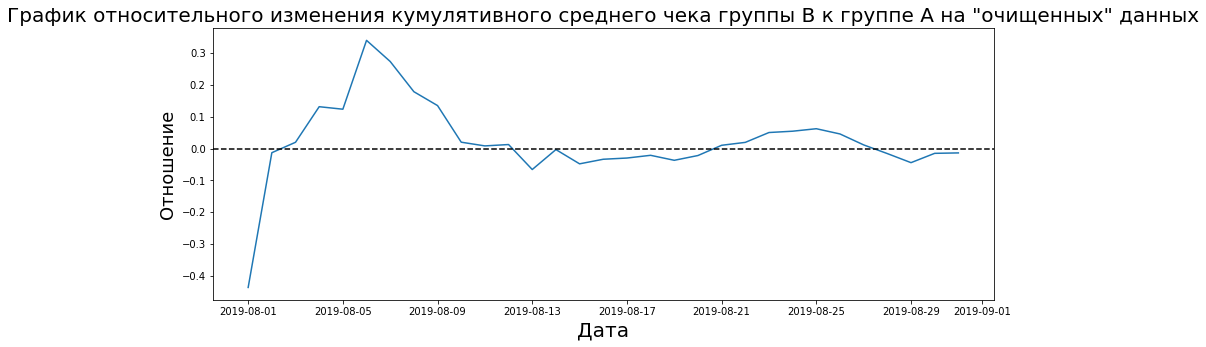

In [74]:
plt.figure(figsize=(14,5))
plt.plot(fil_cumrevenueA['date'], (fil_cumrevenueB['revenue']/fil_cumrevenueB['orders'])/(fil_cumrevenueA['revenue']/fil_cumrevenueA['orders']) - 1)
plt.title('График относительного изменения кумулятивного среднего чека группы В к группе А на "очищенных" данных', fontsize=20)
plt.xlabel('Дата', fontsize=20)
plt.ylabel("Отношение",  fontsize=18)
plt.axhline(y=0, color='black', linestyle='--');

На графике, построенном по "очищенным" данным, мы видим, что сначала средний чек группы В значительно превысил средний чек группы А, но потом сравнялся с ней и находился примерно на тех же значениях до конца теста.

## Подведение итогов и принятие решения по тесту.

По итогам месяца проведения А/В-теста мы должны принять одно из трех решений:
1. Остановить тест, зафиксировать победу одной из групп;
2. Остановить тест, зафиксировать отсутствие различий между группами;
3. Продолжить тест.

Напомним, что мы проверяли следующую бизнес-гипотезу: **"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"**.

Особенностью проведения данного А/В-теста является то, что нами были обнаружены 58 пользователей, которые совершили покупки, находясь и в группе `A` и в группе `B`. Вероятно, возник какой-то сбой в записи логов, либо в распределении пользователей по группам. Мы исключили данные о покупках таких пользователей, так как они составляли значительную часть от общего количества покупок, что могло негативно сказаться на результатах. Однако у нас нет возможности удалить информацию об этих пользователях из данных по посещениям, по причине того, что у нас есть только обезличенные данные, но так как количество посещений измеряется в десятках тысяч, то посещения 58 пользователей не окажут большого влияния.

Также мы определили выбросы: пользователи, у которых 3 и более покупок, а также пользователей с заказами дороже 53000 рублей.
***
Подведем итоги, которые мы получили в ходе анализа результатов теста:

1. При проведении статистических тестов на "сырых" данных:
   - у нас есть основания для того, чтобы отвергнуть нулевую гипотезу о том, что  различий в среднем количестве заказов на посетителя в группе А и в группе В нет. При этом относительный прирост кумулятивной средней конверсии в группе В по отношению к группе А составил 16%.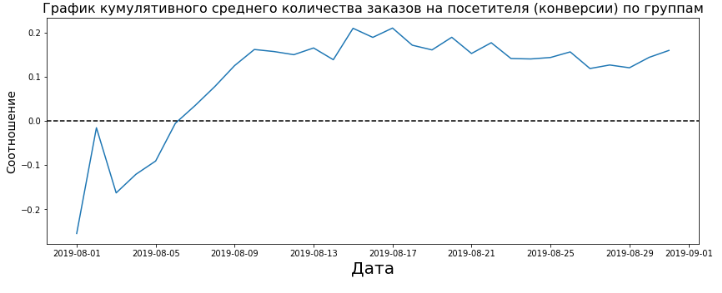 На графике мы видим, как группа В на протяжении большей части теста достаточно стабильно превосходит группу А.


   - у нас нет оснований отвергнуть нулевую гипотезу, которая гласит, что различий в среднем чеке заказа между группами нет. При этом относительный прирост кумулятивного среднего чека в группе В относительно группы А составил 28.7%.
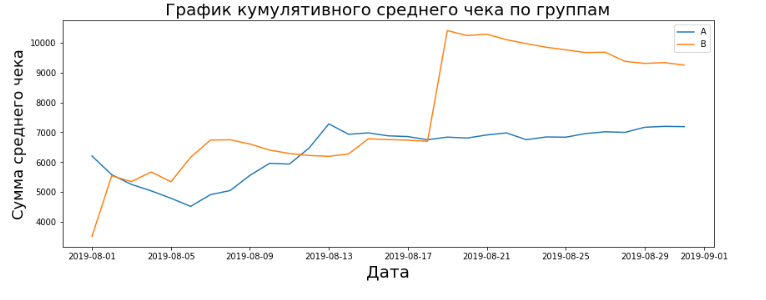 На графике мы видим, как выброс сильно исказил кривую группы В.
***
2. При проведении статистических тестов на "очищенных" данных:
   - есть основания для того, чтобы отвергнуть нулевую гипотезу о том, что  различий в среднем количестве заказов на посетителя в группе А и в группе В нет. При этом относительный прирост кумулятивной средней конверсии в группе В по отношению к группе А на очищенных данных составил 19.26%, то есть стал еще больше чем при анализе "сырых" данных.
   - у нас снова нет оснований отвергнуть нулевую гипотезу, которая гласит, что различий в среднем чеке заказа между группами нет, даже на "очищенных" данных. При этом прирост кумулятивного среднего чека в группе В относительно группы А составил всего чуть больше одного процента, что подтверждает наше предположение об искажающих картину выбросах.
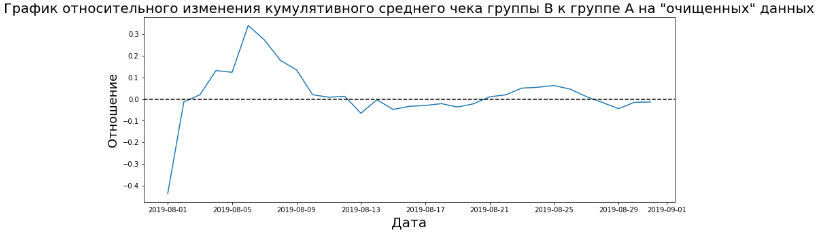
***
**Мы видим, что графики стабилизировались и нет оснований ожидать, что они в дальнейшем начнут заметно колебаться. В настоящий момент мы можем с большой долей вероятности утверждать, что добавление формы подписки на все основные страницы, чтобы повысить конверсию и средний чек заказа позволит нам значительно увеличить конверсию посетителей в покупателей, однако ожидать роста суммы среднего чека не приходится.**

***Стоит остановить тест и признать группу В победителем с учетом, что победа одержана наполовину: в части конверсии пользователей в покупателей, а статистически значимых изменений в сумме среднего чека обнаружить не удалось.***

